### Porting Charlie's umbrella sampling code from CosmoSIS to stand-alone


In [23]:
import numpy as np

fa1 = 0.1; fx1 =  4.0; fy1 =  80.0; fsx1 = 0.1; fsy1 = .2; fr1 = -.7
fa2 = 0.1; fx2 =  -4.0; fy2 =  80.0; fsx2 = 0.1; fsy2 = .2; fr2 = .8
def smiley_face_pdf(xin, args):
    x = xin[:,0]; y = xin[:,1]
    fx1, fy1, fx2, fy2 = args
    # Gaussian pdfs 1 and 2
    res  = fa1*np.exp(-0.5/(1 - fr1**2)*( ((x-fx1)/fsx1)**2 + ((y-fy1)/fsy1)**2 + 2*fr1*(x-fx1)*(y-fy1)/(fsx1*fsy1) )) 
    res += fa2*np.exp(-0.5/(1 - fr2**2)*( ((x-fx2)/fsx2)**2 + ((y-fy2)/fsy2)**2 + 2*fr2*(x-fx2)*(y-fy2)/(fsx2*fsy2) ))
    # + Rosenbrock pdf
    res += np.exp(-(100.*(y-x**2)**2 + (4.0-x)**2)/20.0)
    return np.log(res)

def gaussian2d(x, sig1, sig2, r):
    """2d Gaussian with non-zero correlation coefficient r
    vectorized version of the function"""
    #sig1, sig2, r = args[0], args[1], args[2]
    r2 = r*r
    return -0.5*((x[:,0]/sig1)**2+(x[:,1]/sig2)**2-2.0*r*x[:,0]*x[:,1]/(sig1*sig2))/(1.0-r2) - (2*np.pi*sig1*sig2) - np.sqrt(1.0-r2)


In [24]:
def GR_indicator(ipar_active):
    """
    ipar_active = vector of integers indicating whether parameter is "active" i.e. it is sampled (1) or "inactive", i.e. 
    it kept fixed at the initial values
    """
    # calculate the effective number of parameters if some are specified to be fixed
    ia = (ipar_active == 1)
    npareff = np.size(ipar_active[ia])
    
    # calculate Gelman & Rubin convergence indicator
    mwc = mw/(nchain-1.0)
    swc = sw/(nchain-1.0)-np.power(mwc,2)

    for i in range(npareff):
        # within chain variance
        Wgr[i] = np.sum(swc[:,i])/nwalkers
        # mean of the means over Nwalkers
        m[i] = np.sum(mwc[:,i])/nwalkers
        # between chain variance
        Bgr[i] = nchain*np.sum(np.power(mwc[:,i]-m[i],2))/(nwalkers-1.0)
        # Gelman-Rubin R factor
        Rgr[i] = (1.0 - 1.0/nchain + Bgr[i]/Wgr[i]/nchain)*(nwalkers+1.0)/nwalkers - (nchain-1.0)/(nchain*nwalkers)
        tacorx = acor.acor(mutx[i])[0]; taux[i].append(np.max(tacorx))
        Rval[i].append(Rgr[i]-1.0)
        print "nchain=",nchain
        print "R values for parameters:", Rgr

def lngauss(x, mu, icov):
    diff = x - mu
    return -0.5 * np.dot(diff.T, np.dot(icov, diff.T))

In [25]:
def MCMCsample(x, nparams=2, nwalkers=100, nRval=100, loglike = None, ipar_active = None, params=[], nsteps=1000000000, Rlim = 1.001):
    """
    MCMC sampler implementing the Goodman & Weare (2010) affine-invariant algorithm
    inner loop is vectorized
    
    run for nsteps or until R_GR=Rlim is reached, whichever comes first
    
    written by Andrey Kravtsov (2014-2016)
    """
    
    try:
        import acor
    except:
        raise Exception("acor package is not installed! do: pip install acor")
        
    # parameters used to draw random number with the GW10 proposal distribution
    ap = 2.0; api = 1.0/ap; asqri=1.0/np.sqrt(ap); afact=(ap-1.0)

    # calculate effective number of parameters if some are specified to be fixed
    ia = (ipar_active==1)
    npareff = np.size(ipar_active[ia])
    print "starting sampling with %d active parameters of the total %d parameters"%(npareff, nparams)
    
    # initialize some auxiliary arrays and variables 
    chain = []; Rval = []; 

    naccept = 0; ntry = 0; nchain = 0
    mw = np.zeros((nwalkers,npareff)); sw = np.zeros((nwalkers,npareff))
    m = np.zeros(npareff); Wgr = np.zeros(npareff); Bgr = np.zeros(npareff); Rgr = np.zeros(npareff)
    
    mutx = []; taux = []
    for i in range(npareff): 
        mutx.append([]); taux.append([])
        Rval.append([])

    gxo = np.zeros((2,nwalkers/2))
    gxo[0,:] = loglike(x[0,:,:], *params); gxo[1,:] = loglike(x[1,:,:], *params)
    converged = False;
    while not converged:
        # for parallelization (not implemented here but the MPI version is available)
        # the walkers are split into two complementary sub-groups (see Foreman-Mackey et al. 2012)
        for kd in range(2):
            k = abs(kd-1)
            # vectorized inner loop of walkers stretch move in the Goodman & Weare sampling algorithm
            xchunk = x[k,:,:]
            jcompl = np.random.randint(0,nwalkers/2,nwalkers/2)
            xcompl = x[kd,jcompl,:]
            gxold  = gxo[k,:]
            zf= np.random.rand(nwalkers/2)   # the next few steps implement Goodman & Weare sampling algorithm
            zf = zf * afact; zr = (1.0+zf)*(1.0+zf)*api
            zrtile = np.transpose(np.tile(zr,(nparams,1))) # duplicate zr for nparams
            xtry  = xcompl + zrtile*(xchunk-xcompl)
            gxtry = loglike(xtry, *params); gx    = gxold 
            gr   = gxtry - gx
            iacc = np.where(gr>0.)
            xchunk[iacc] = xtry[iacc]
            gxold[iacc] = gxtry[iacc]
            aprob = (npareff-1)*np.log(zr) + (gxtry - gx)
            u = np.random.uniform(0.0,1.0,np.shape(xchunk)[0])        
            iprob = np.where(aprob>np.log(u))
            xchunk[iprob] = xtry[iprob]
            gxold[iprob] = gxtry[iprob]
            naccept += len(iprob[0])

            x[k,:,ia] = np.transpose(xchunk[:,ia])
            gxo[k,:] = gxold        
            xdum = x[:,:,ia]

            for i in range(nwalkers/2):
                chain.append(np.array(xdum[k,i,:]))

            for i in range(nwalkers/2):
                mw[k*nwalkers/2+i,:] += xdum[k,i,:]
                sw[k*nwalkers/2+i,:] += xdum[k,i,:]**2
                ntry += 1

        nchain += 1
        
        # compute means for the auto-correlation time estimate
        for i in range(npareff):
            mutx[i].append(np.sum(xdum[:,:,i])/(nwalkers))

        # compute Gelman-Rubin indicator for all parameters
        #if ( nchain >= nwalkers/2 and nchain%nRval == 0):
        if ( nchain%nRval == 0):
            # calculate Gelman & Rubin convergence indicator
            mwc = mw/(nchain-1.0)
            swc = sw/(nchain-1.0)-np.power(mwc,2)

            for i in range(npareff):
                # within chain variance
                Wgr[i] = np.sum(swc[:,i])/nwalkers
                # mean of the means over Nwalkers
                m[i] = np.sum(mwc[:,i])/nwalkers
                # between chain variance
                Bgr[i] = nchain*np.sum(np.power(mwc[:,i]-m[i],2))/(nwalkers-1.0)
                # Gelman-Rubin R factor
                Rgr[i] = (1.0 - 1.0/nchain + Bgr[i]/Wgr[i]/nchain)*(nwalkers+1.0)/nwalkers - (nchain-1.0)/(nchain*nwalkers)
                tacorx = acor.acor(np.abs(mutx[i]))[0]; taux[i].append(np.max(tacorx))
                Rval[i].append(Rgr[i]-1.0)
            print "nchain=",nchain
            print "R values for parameters:", Rgr
            print "tcorr =", np.max(tacorx)
            if (np.max(np.abs(Rgr-1.0)) < np.abs(Rlim-1.0)) or (nchain >= nsteps): converged = True
        
    print "MCMC sampler generated ",ntry," samples using", nwalkers," walkers"
    print "with step acceptance ratio of", 1.0*naccept/ntry
        
    # record integer auto-correlation time at the final iteration
    nthin = int(tacorx)

    return chain, Rval, nthin

def MCMCsample_init(nparams=2, nwalkers=100, x0=None, step=None, ipar_active=None):
    """
    distribute initial positions of walkers in an isotropic Gaussian around the initial point
    """
    np.random.seed()
    
    # in this implementation the walkers are split into 2 subgroups and thus nwalkers must be divisible by 2
    if nwalkers%2:
        raise ValueError("MCMCsample_init: nwalkers must be divisible by 2!")
         
    x = np.zeros([2,nwalkers/2,nparams])

    for i in range(nparams):
        x[:,:,i] = np.reshape(np.random.normal(x0[i],step[i],nwalkers),(2,nwalkers/2))
    ina = (ipar_active==0)
    if np.size(ina) > 0:
        x[:,:,ina] = x0[ina]
    return x


In [26]:
# initialize walkers in a Gaussian ball of a specified radius defined in step

nwalkers = 200

x0 = np.array([0., 0.]); step = np.array([0.1,0.1])

# if entry is set to 0 parameter is not sampled but is kept at the initial value
ipar_active = np.array([1, 1])

x = MCMCsample_init(nparams=2, nwalkers=nwalkers, x0=x0, step=step, ipar_active=ipar_active)

In [27]:
from time import clock

args = np.zeros(3)
args[0] = 1.0; args[1] = 1.0; args[2] = 0.95

t0 = clock()
# run sampler
chain, Rval, nthin = MCMCsample(x, nparams=2, nwalkers=200, nRval=10000, loglike = gaussian2d, 
                                ipar_active = ipar_active, params=args, nsteps=10000, Rlim = 1.001 )

#cov = [[1.0, 0.95], [0.95, 1.0]]
#icov = np.linalg.inv(cov)
#args = [x0, icov]

#chain, Rval, nthin = MCMCsample(x, nparams=2, nwalkers=200, nRval=10000, modelpdf = lngauss, 
#                                ipar_active = ipar_active, params=args, nsteps=10000, Rlim = 1.001 )

print "sampled in ", clock()-t0, " seconds"

starting sampling with 2 active parameters of the total 2 parameters
nchain= 10000
R values for parameters: [ 1.00338029  1.00348144]
tcorr = 12.3461060946
MCMC sampler generated  2000000  samples using 200  walkers
with step acceptance ratio of 0.6601345
sampled in  14.0955661723  seconds


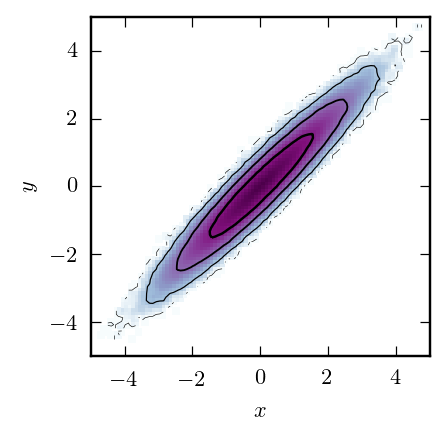

In [29]:
%matplotlib inline

x1d = zip(*chain)[0]; x2d = zip(*chain)[1]; 
nburn = int(20*nwalkers*nthin)
x1 = x1d[nburn:]; x2 = x2d[nburn:]; 

from plot_utils import plot_pretty, plot_2d_dist

plot_pretty()
#clevs = (0.683, 0.955, 0.997) # standard contour levels
clevs = (0.683, 0.955, 0.997, 0.9999)

plot_2d_dist(x1, x2, xlim=[-5,5], ylim =[-5,5], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$x$', ylabel='$y$')

In [20]:
def lngauss(x, mu, icov):
    diff = x - mu
    return -np.dot(diff, np.dot(icov,diff))/2.0

In [21]:
import emcee 
from time import clock 

ndim = 2
means = np.array([0., 0.])

cov = [[1.0, 0.95], [0.95, 1.0]]
icov = np.linalg.inv(cov)

ndim = 2; nwalkers = 200; 

x0 = np.array([0., 0.]); step = np.array([0.1,0.1])
pp = np.vstack([x0 + np.random.normal(scale=step, size=len(x0))
                for i in range(nwalkers)])

t0 = clock()
# create the emcee EnsembleSampler object, giving it our log_likelihood function.
sampler = emcee.EnsembleSampler(nwalkers, ndim, lngauss, args=[x0, icov])

# arbitrary burn-in
pos, prob, state = sampler.run_mcmc(pp, 1000)
sampler.reset()

# Run the sampler!  This will take 10 seconds or more.
pos, prob, state = sampler.run_mcmc(pp, 10000)

print "emcee sampled in ", clock()-t0, " seconds"

emcee sampled in  10.567237477  seconds


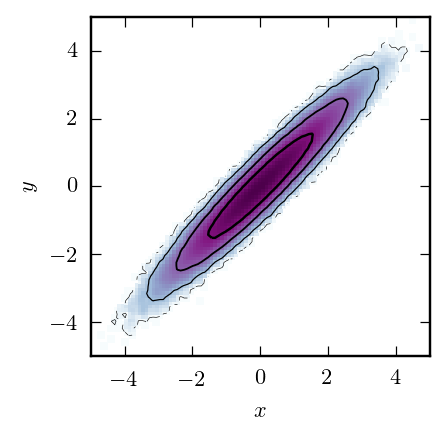

In [30]:
x1d = sampler.flatchain[:,0]; x2d = sampler.flatchain[:,1]; 
nburn = int(20*nwalkers*nthin)
x1 = x1d[nburn:]; x2 = x2d[nburn:]; 

#clevs = (0.683, 0.955, 0.997) # standard contour levels
clevs = (0.683, 0.955, 0.997, 0.9999)
plot_2d_dist(x1, x2, xlim=[-5,5], ylim =[-5,5], nxbins=100, nybins=100, clevs=clevs, smooth=True, xlabel='$x$', ylabel='$y$')

In [2]:
import numpy as np
cov = [[1.0, 0.95], [0.95, 1.0]]
icov = np.linalg.inv(cov)
print icov

[[ 10.25641026  -9.74358974]
 [ -9.74358974  10.25641026]]


In [32]:
import usample.usample
import numpy as np

def log_prob_fn(p):
    
    invSigma = [[ 10.25641026,  -9.74358974], [ -9.74358974,  10.25641026]]
    
    lpf = - 0.5 * np.dot(p , np.dot( invSigma , p ) )
    
    return lpf

#
# Now create the umbrella sampler object 
#  

us = usample.UmbrellaSampler( log_prob_fn )

#
# Now add some umbrellas.
# First, define some temperatures to run with. 
#
 
temps = np.linspace( 1 , 20 , 8 ) 

#
# Then add an umbrella at each temperature. Use four walkers, and give some initial conditions
# Note that you should have the same number of walkers per window (at the moment)
#

for t in temps:
    us.add_umbrella( t , numwalkers=4 , ic=np.zeros(2) )

# 
# Then run for 10000 steps in each window.
# Output stats every [freq] steps
# Try to replica exchange [repex]-many walkers every [freq] steps
#


pos_us, weights_us, prob_us = us.run(10000 , freq=500, repex=0 )


 :- Completed 500 of 10000 iterations.
 :- Completed 1000 of 10000 iterations.
 :- Completed 1500 of 10000 iterations.
 :- Completed 2000 of 10000 iterations.
 :- Completed 2500 of 10000 iterations.
 :- Completed 3000 of 10000 iterations.
 :- Completed 3500 of 10000 iterations.
 :- Completed 4000 of 10000 iterations.
 :- Completed 4500 of 10000 iterations.
 :- Completed 5000 of 10000 iterations.
 :- Completed 5500 of 10000 iterations.
 :- Completed 6000 of 10000 iterations.
 :- Completed 6500 of 10000 iterations.
 :- Completed 7000 of 10000 iterations.
 :- Completed 7500 of 10000 iterations.
 :- Completed 8000 of 10000 iterations.
 :- Completed 8500 of 10000 iterations.
 :- Completed 9000 of 10000 iterations.
 :- Completed 9500 of 10000 iterations.
 :- Completed 10000 of 10000 iterations.
    [d]: z values [ 0.0121235   0.04453591  0.07677301  0.10899565  0.1411987   0.17336375
  0.20547892  0.23753056]


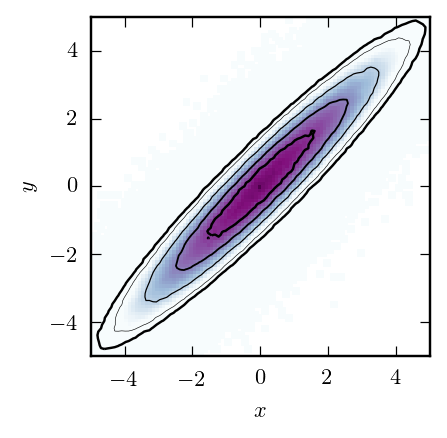

In [35]:
%matplotlib inline 

from plot_utils import plot_pretty, plot_2d_dist

plot_pretty()
x1d = pos_us[:,0].ravel(); x2d = pos_us[:,1].ravel(); 
weights = weights_us.ravel()

clevs = (0.683, 0.955, 0.997, 0.9999, 0.99999) # standard contour levels

plot_2d_dist(x1d, x2d, xlim=[-5,5], ylim =[-5,5], nxbins=100, nybins=100, 
             clevs=clevs, weights=weights, smooth=False, 
             xlabel='$x$', ylabel='$y$')